# IMPORT LIBRARIES AND DATASETS

In [ ]:
#!pip install --upgrade tensorflow==2.0
#!pip install plotly
#!pip install --upgrade nbformat
#!pip install nltk
#!pip install spacy # spaCy is an open-source software library for advanced natural language processing
#!pip install WordCloud
#!pip install gensim  # Gensim is an open-source library for unsupervised topic modeling and natural language processing

In [3]:
import nltk
#nltk.download('punkt')

In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

# import keras
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model

In [5]:
# load the data
df_true = pd.read_csv("True.csv")
df_fake = pd.read_csv("Fake.csv")

In [6]:
print(f'we have {df_true.shape[0]} samples of True values' )
print(f'we have {df_fake.shape[0]} samples of True values' )

we have 21417 samples of True values
we have 23481 samples of True values


In [7]:
print('\n True Values \n')
print(df_fake.isnull().sum())
print('\n Fake Values \n')
print(df_true.isnull().sum())


 True Values 

title      0
text       0
subject    0
date       0
dtype: int64

 Fake Values 

title      0
text       0
subject    0
date       0
dtype: int64


In [8]:
df_true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [9]:
df_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


# PERFORM EXPLORATORY DATA ANALYSIS

In [10]:
# add a target class column to indicate whether the news is real or fake
df_true['isfake'] = 1
df_true.head()

,title,text,subject,date,isfake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [11]:
df_fake['isfake'] = 0
df_fake.head()

,title,text,subject,date,isfake
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [12]:
# Concatenate Real and Fake News
df = pd.concat([df_true, df_fake]).reset_index(drop = True)
df

,title,text,subject,date,isfake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1
...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0


In [13]:
df.drop(columns = ['date'], inplace = True)

In [14]:
# combine title and text together
df['original'] = df['title'] + ' ' + df['text']
df.head()

,title,text,subject,isfake,original
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1,Trump wants Postal Service to charge 'much mor...


In [15]:
df['original'][0]

'As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non

# PERFORM DATA CLEANING

In [16]:
# download stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jhona\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
# Obtain additional stopwords from nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [18]:
# Remove stopwords and remove words with 2 or less characters
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)
            
    return result

In [19]:
# Apply the function to the dataframe
df['clean'] = df['original'].apply(preprocess)

In [20]:
# Show original news
df['original'][0]

'As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non

In [21]:
# Show cleaned up news after removing stopwords
print(df['clean'][0])

['budget', 'fight', 'looms', 'republicans', 'flip', 'fiscal', 'script', 'washington', 'reuters', 'head', 'conservative', 'republican', 'faction', 'congress', 'voted', 'month', 'huge', 'expansion', 'national', 'debt', 'cuts', 'called', 'fiscal', 'conservative', 'sunday', 'urged', 'budget', 'restraint', 'keeping', 'sharp', 'pivot', 'republicans', 'representative', 'mark', 'meadows', 'speaking', 'face', 'nation', 'drew', 'hard', 'line', 'federal', 'spending', 'lawmakers', 'bracing', 'battle', 'january', 'return', 'holidays', 'wednesday', 'lawmakers', 'begin', 'trying', 'pass', 'federal', 'budget', 'fight', 'likely', 'linked', 'issues', 'immigration', 'policy', 'november', 'congressional', 'election', 'campaigns', 'approach', 'republicans', 'seek', 'control', 'congress', 'president', 'donald', 'trump', 'republicans', 'want', 'budget', 'increase', 'military', 'spending', 'democrats', 'want', 'proportional', 'increases', 'defense', 'discretionary', 'spending', 'programs', 'support', 'educati

In [22]:
df

,title,text,subject,isfake,original,clean
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1,"As U.S. budget fight looms, Republicans flip t...","[budget, fight, looms, republicans, flip, fisc..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1,U.S. military to accept transgender recruits o...,"[military, accept, transgender, recruits, mond..."
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1,Senior U.S. Republican senator: 'Let Mr. Muell...,"[senior, republican, senator, mueller, washing..."
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1,FBI Russia probe helped by Australian diplomat...,"[russia, probe, helped, australian, diplomat, ..."
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1,Trump wants Postal Service to charge 'much mor...,"[trump, wants, postal, service, charge, amazon..."
...,...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,0,McPain: John McCain Furious That Iran Treated ...,"[mcpain, john, mccain, furious, iran, treated,..."
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,0,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,"[justice, yahoo, settles, mail, privacy, class..."
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,0,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,"[sunnistan, allied, safe, zone, plan, territor..."
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,0,How to Blow $700 Million: Al Jazeera America F...,"[blow, million, jazeera, america, finally, cal..."


In [23]:
# Obtain the total words present in the dataset
list_of_words = []
for i in df.clean:
    for j in i:
        list_of_words.append(j)


In [24]:
len(list_of_words)

9276947

In [25]:
# Obtain the total number of unique words
total_words = len(list(set(list_of_words)))
total_words

108704

In [26]:
# join the words into a string
df['clean_joined'] = df['clean'].apply(lambda x: " ".join(x))

In [27]:
df

,title,text,subject,isfake,original,clean,clean_joined
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1,"As U.S. budget fight looms, Republicans flip t...","[budget, fight, looms, republicans, flip, fisc...",budget fight looms republicans flip fiscal scr...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1,U.S. military to accept transgender recruits o...,"[military, accept, transgender, recruits, mond...",military accept transgender recruits monday pe...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1,Senior U.S. Republican senator: 'Let Mr. Muell...,"[senior, republican, senator, mueller, washing...",senior republican senator mueller washington r...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1,FBI Russia probe helped by Australian diplomat...,"[russia, probe, helped, australian, diplomat, ...",russia probe helped australian diplomat washin...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1,Trump wants Postal Service to charge 'much mor...,"[trump, wants, postal, service, charge, amazon...",trump wants postal service charge amazon shipm...
...,...,...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,0,McPain: John McCain Furious That Iran Treated ...,"[mcpain, john, mccain, furious, iran, treated,...",mcpain john mccain furious iran treated sailor...
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,0,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,"[justice, yahoo, settles, mail, privacy, class...",justice yahoo settles mail privacy class actio...
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,0,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,"[sunnistan, allied, safe, zone, plan, territor...",sunnistan allied safe zone plan territorial bo...
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,0,How to Blow $700 Million: Al Jazeera America F...,"[blow, million, jazeera, america, finally, cal...",blow million jazeera america finally calls qui...


In [28]:
df['clean_joined'][0]

'budget fight looms republicans flip fiscal script washington reuters head conservative republican faction congress voted month huge expansion national debt cuts called fiscal conservative sunday urged budget restraint keeping sharp pivot republicans representative mark meadows speaking face nation drew hard line federal spending lawmakers bracing battle january return holidays wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy november congressional election campaigns approach republicans seek control congress president donald trump republicans want budget increase military spending democrats want proportional increases defense discretionary spending programs support education scientific research infrastructure public health environmental protection trump administration willing going increase defense discretionary spending percent meadows chairman small influential house freedom caucus said program democrats saying need government raise 

# VISUALIZE CLEANED UP DATASET

In [29]:
df.head(5)

,title,text,subject,isfake,original,clean,clean_joined
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1,"As U.S. budget fight looms, Republicans flip t...","[budget, fight, looms, republicans, flip, fisc...",budget fight looms republicans flip fiscal scr...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1,U.S. military to accept transgender recruits o...,"[military, accept, transgender, recruits, mond...",military accept transgender recruits monday pe...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1,Senior U.S. Republican senator: 'Let Mr. Muell...,"[senior, republican, senator, mueller, washing...",senior republican senator mueller washington r...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1,FBI Russia probe helped by Australian diplomat...,"[russia, probe, helped, australian, diplomat, ...",russia probe helped australian diplomat washin...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1,Trump wants Postal Service to charge 'much mor...,"[trump, wants, postal, service, charge, amazon...",trump wants postal service charge amazon shipm...


<AxesSubplot:xlabel='count', ylabel='subject'>

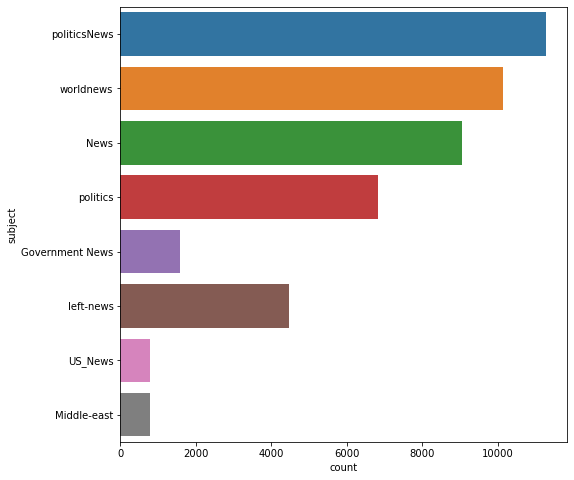

In [30]:
# plot the number of samples in 'subject'
plt.figure(figsize = (8, 8))
sns.countplot(y = "subject", data = df)

<AxesSubplot:xlabel='count', ylabel='isfake'>

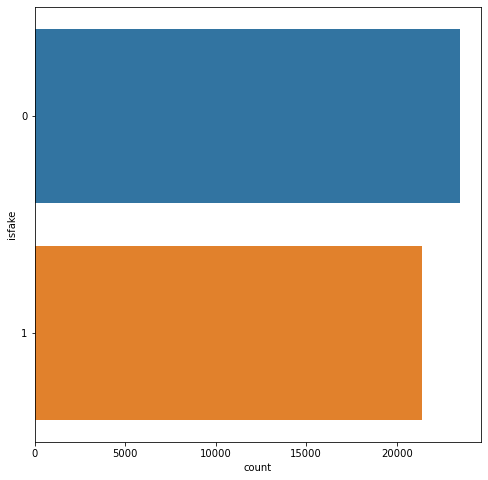

In [40]:
# plot the number of samples in 'subject'
plt.figure(figsize = (8, 8))
sns.countplot(y = "isfake", data = df)

In [32]:
# plot the word cloud for text that is Real
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words)
wc.generate(" ".join(df[df.isfake == 1].clean_joined))

<Figure size 1440x1440 with 0 Axes>

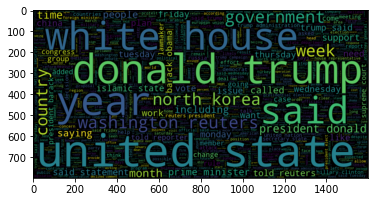

In [33]:
plt.imshow(wc, interpolation = 'bilinear')

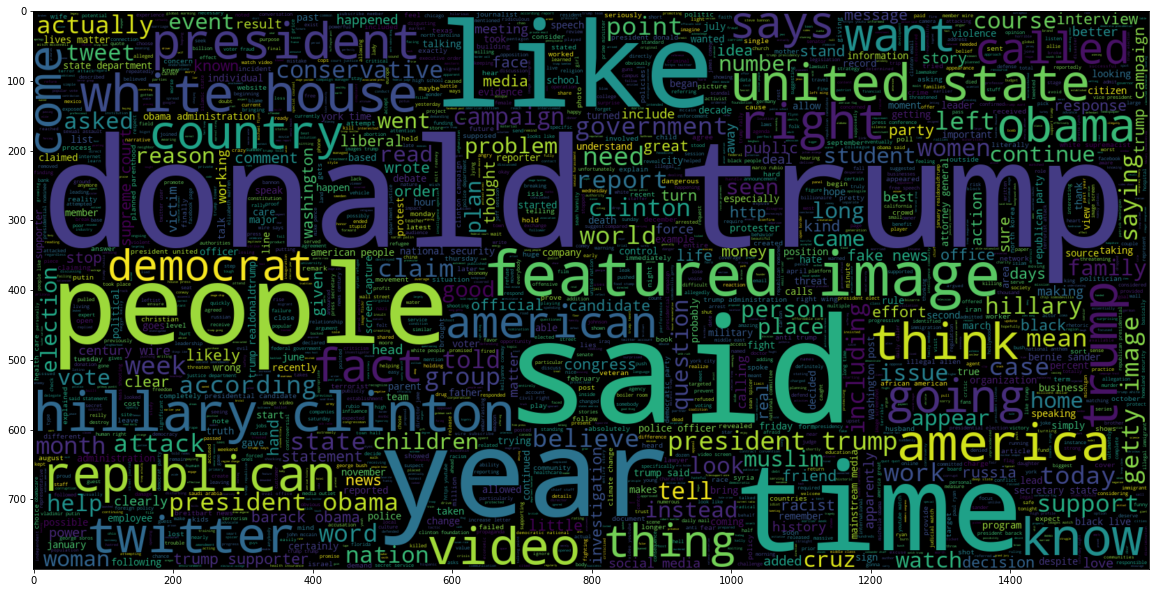

In [34]:
# plot the word cloud for text that is Fake
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.isfake == 0].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')

In [35]:
# length of maximum document will be needed to create word embeddings 
maxlen = -1
for doc in df.clean_joined:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is =", maxlen)

The maximum number of words in any document is = 4405


# PREPARE THE DATA BY PERFORMING TOKENIZATION AND PADDING

In [37]:
# split data into test and train 
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.clean_joined, df.isfake, test_size = 0.2)

In [38]:
from nltk import word_tokenize

In [41]:
# Create a tokenizer to tokenize the words and create sequences of tokenized words
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)


In [42]:
print("The encoding for document\n",df.clean_joined[0],"\n is : ",train_sequences[0])

The encoding for document
 budget fight looms republicans flip fiscal script washington reuters head conservative republican faction congress voted month huge expansion national debt cuts called fiscal conservative sunday urged budget restraint keeping sharp pivot republicans representative mark meadows speaking face nation drew hard line federal spending lawmakers bracing battle january return holidays wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy november congressional election campaigns approach republicans seek control congress president donald trump republicans want budget increase military spending democrats want proportional increases defense discretionary spending programs support education scientific research infrastructure public health environmental protection trump administration willing going increase defense discretionary spending percent meadows chairman small influential house freedom caucus said program democrats say

In [43]:
# Add padding can either be maxlen = 4406 or smaller number maxlen = 40 seems to work well based on results
padded_train = pad_sequences(train_sequences,maxlen = 40, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences,maxlen = 40, truncating = 'post') 

In [44]:
for i,doc in enumerate(padded_train[:2]):
     print("The padded encoding for document",i+1," is : ",doc)

The padded encoding for document 1  is :  [13222 12069  2164 11278  3501    35    39   985   669  9375   548   793
    27 13565    76   120    39    48   495   207    58  5686   169     4
  1245  2441    23  7027  2164 11278 13222 12069    74   217  8810   402
  2825  1121    39   985]
The padded encoding for document 2  is :  [  15    8   46 1499  362  603   70 1295   25    9   15    8    2   91
  991 4747   72   70 1611   45   20   68  117  450 5334 1747  227  517
  868   90  991 3366  362  603  187  209 2816 3063   16   22]


# BUILD AND TRAIN THE MODEL 

In [45]:
# Sequential Model
model = Sequential()

# embeddidng layer
model.add(Embedding(total_words, output_dim = 128))
# model.add(Embedding(total_words, output_dim = 240))


# Bi-Directional RNN and LSTM
model.add(Bidirectional(LSTM(128)))

# Dense layers
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1,activation= 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         13914112  
                                                                 
 bidirectional (Bidirectiona  (None, 256)              263168    
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 14,210,305
Trainable params: 14,210,305
Non-trainable params: 0
_________________________________________________________________


In [46]:
total_words

108704

In [48]:
y_train = np.asarray(y_train)

In [49]:
# train the model
model.fit(padded_train, y_train, batch_size = 64, validation_split = 0.1, epochs = 2)

Epoch 1/2
506/506 [==============================] - 74s 139ms/step - loss: 0.0364 - acc: 0.9857 - val_loss: 0.0053 - val_acc: 0.9983
Epoch 2/2
506/506 [==============================] - 69s 136ms/step - loss: 0.0021 - acc: 0.9996 - val_loss: 0.0056 - val_acc: 0.9983


# ASSESS TRAINED MODEL PERFORMANCE


In [50]:
# make prediction
pred = model.predict(padded_test)

In [51]:
# if the predicted value is >0.5 it is real else it is fake
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)

In [52]:
# getting the accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(list(y_test), prediction)

print("Model Accuracy : ", accuracy)

Model Accuracy :  0.9985523385300669


<AxesSubplot:>

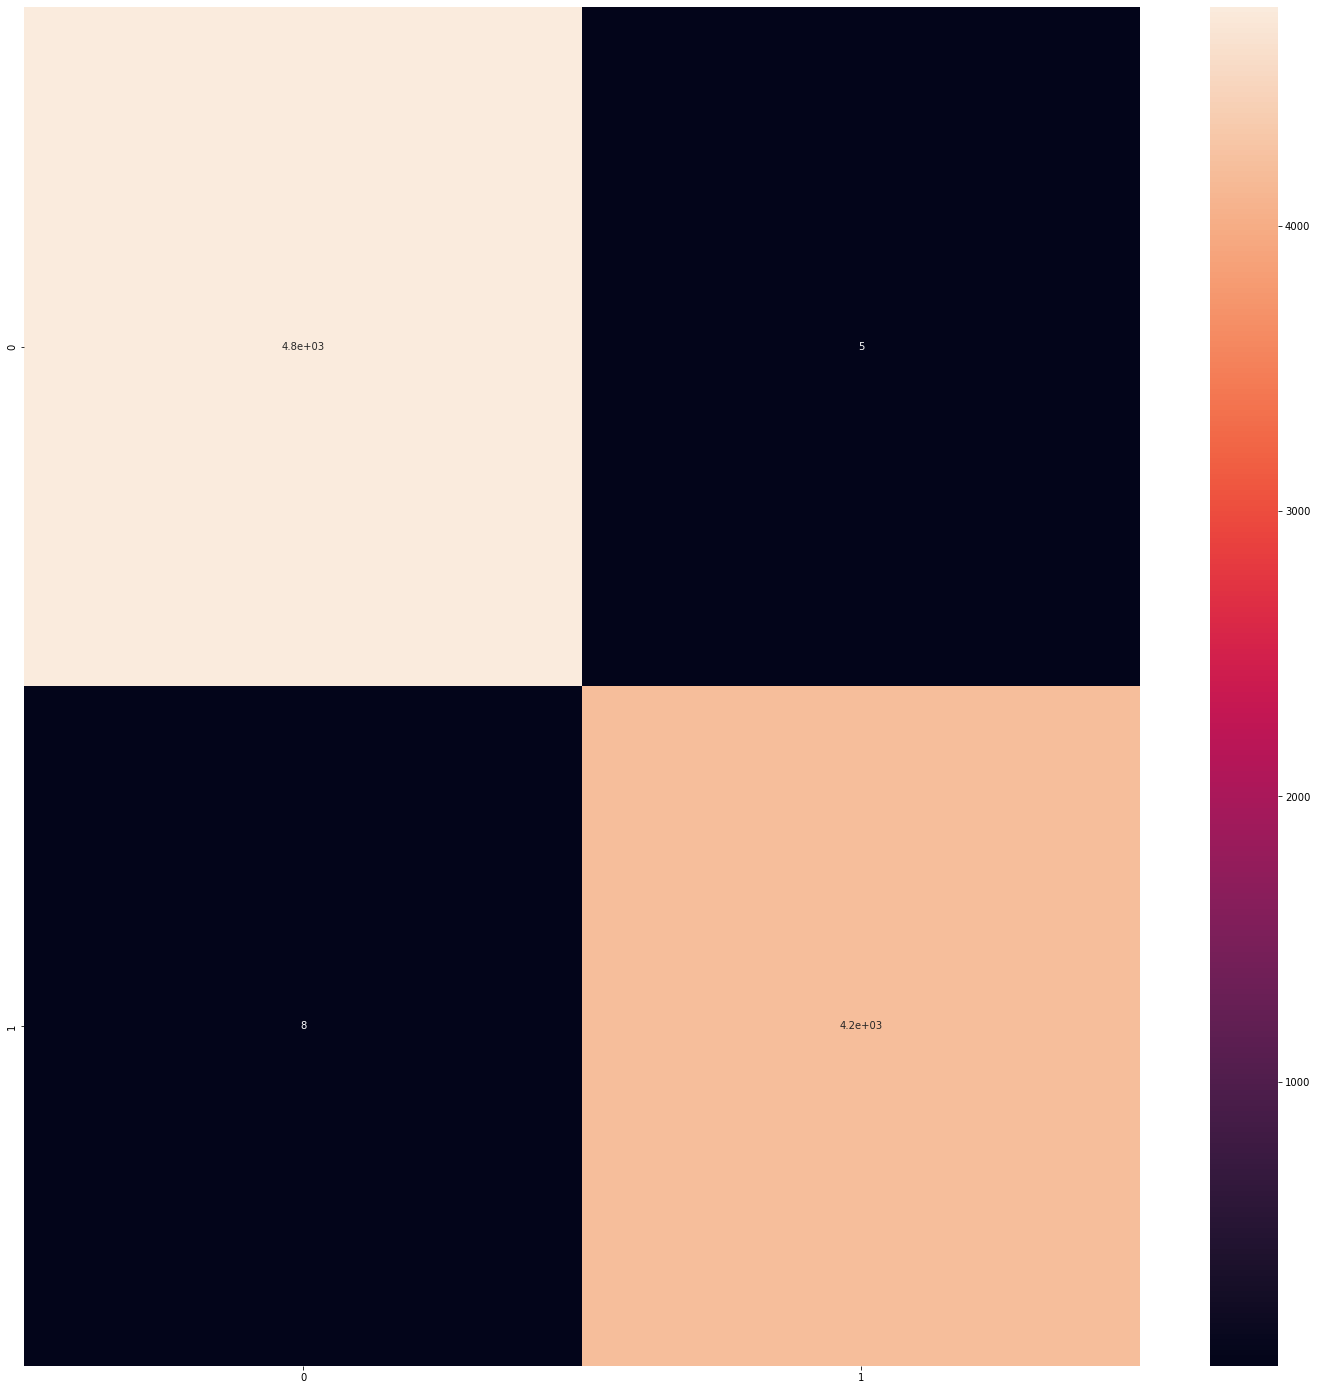

In [53]:
# get the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (25, 25))
sns.heatmap(cm, annot = True)

In [54]:
# category dict
category = { 0: 'Fake News', 1 : "Real News"}